In [31]:
import torch
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

from hydra import initialize, compose
from hydra.utils import instantiate

from pathlib import Path

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog
from bliss.encoder.encoder import Encoder
from case_studies.dc2_cataloging.utils.notebook_variables import NoteBookVariables

from pytorch_lightning.utilities import move_data_to_device

output_dir = Path("./plot_output/credible_interval_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-29-3/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

bands = ("u", "g", "r", "i", "z", "y")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
tile_slen = notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = notebook_cfg.notebook_var.r_band_min_flux

dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

bliss_encoder: Encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder = bliss_encoder.eval()

In [4]:
def move_tile_cat_to_device(ori_tile_cat: TileCatalog, device):
    tile_dict = move_data_to_device(ori_tile_cat.data, device=device)
    return TileCatalog(tile_dict)

In [5]:
lower_q = 0.05
upper_q = 0.95
bliss_ci_tile_cat_list = []
target_tile_cat_list = []
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch_on_device = move_data_to_device(batch, device=device)
    with torch.no_grad():
        bliss_ci_tile_cat = bliss_encoder.sample_credible_interval(batch_on_device, lower_q, upper_q, use_mode=True)
        bliss_ci_tile_cat = bliss_ci_tile_cat.filter_by_flux(
            min_flux=r_band_min_flux,
            band=2,
        )
    bliss_ci_tile_cat_list.append(move_tile_cat_to_device(bliss_ci_tile_cat, device="cpu"))
    target_tile_cat_list.append(TileCatalog(batch["tile_catalog"]))

100%|██████████| 391/391 [02:16<00:00,  2.86it/s]


In [32]:
locs_sources = 0
locs1_within_ci_num = 0
locs2_within_ci_num = 0
ellipticity_sources = 0
ellipticity1_within_ci_num = 0
ellipticity2_within_ci_num = 0
star_flux_sources = 0
star_flux_within_ci_num = {band: 0 for band in bands}
galaxy_flux_sources = 0
galaxy_flux_within_ci_num = {band: 0 for band in bands}

bliss_locs_list = []
bliss_locs_ci_lower_list = []
bliss_locs_ci_upper_list = []
locs_mask_list = []
target_locs_list = []

for bliss_ci_tile_cat, target_tile_cat in tqdm.tqdm(zip(bliss_ci_tile_cat_list, target_tile_cat_list)):
    bliss_is_on_mask = bliss_ci_tile_cat.is_on_mask.unsqueeze(-1)
    bliss_m = bliss_is_on_mask.shape[-2]
    target_is_on_mask = target_tile_cat.is_on_mask[..., :bliss_m].unsqueeze(-1)
    both_on_mask = bliss_is_on_mask & target_is_on_mask  # (b, nth, ntw, m, 1)
    locs_sources += both_on_mask.sum().item()
    locs_mask_list.append(both_on_mask)
    bliss_locs = bliss_ci_tile_cat["locs"]
    bliss_locs_list.append(bliss_locs)
    bliss_locs_ci_lower = bliss_ci_tile_cat["locs_ci_lower"]  # (b, nth, ntw, m, 2)
    bliss_locs_ci_lower_list.append(bliss_locs_ci_lower)
    bliss_locs_ci_upper = bliss_ci_tile_cat["locs_ci_upper"]
    bliss_locs_ci_upper_list.append(bliss_locs_ci_upper)
    target_locs = target_tile_cat["locs"][..., :bliss_m, :]  # (b, nth, ntw, m, 2)
    target_locs_list.append(target_locs)
    locs_within_ci = (target_locs > bliss_locs_ci_lower) & (target_locs < bliss_locs_ci_upper)  # (b, nth, ntw, m, 2)
    locs1_within_ci_num += (locs_within_ci[..., 0:1] & both_on_mask).sum().item()
    locs2_within_ci_num += (locs_within_ci[..., 1:2] & both_on_mask).sum().item()

    cosmodc2_mask = target_tile_cat["cosmodc2_mask"][..., :bliss_m, :]
    ellipticity_sources += cosmodc2_mask.sum().item()
    ellipticity_mask = both_on_mask & cosmodc2_mask
    bliss_ellipticity_ci_lower = bliss_ci_tile_cat["ellipticity_ci_lower"]  # (b, nth, ntw, m, 2)
    bliss_ellipticity_ci_upper = bliss_ci_tile_cat["ellipticity_ci_upper"]
    target_ellipticity = target_tile_cat["ellipticity"][..., :bliss_m, :]
    ellipticity_within_ci = (target_ellipticity > bliss_ellipticity_ci_lower) & (target_ellipticity < bliss_ellipticity_ci_upper)
    ellipticity1_within_ci_num += (ellipticity_within_ci[..., 0:1] & ellipticity_mask).sum().item()
    ellipticity2_within_ci_num += (ellipticity_within_ci[..., 1:2] & ellipticity_mask).sum().item()

    star_mask = bliss_ci_tile_cat.star_bools & target_tile_cat.star_bools[..., :bliss_m, :]
    star_flux_sources += star_mask.sum().item()
    bliss_star_flux_ci_lower = bliss_ci_tile_cat["star_fluxes_ci_lower"]
    bliss_star_flux_ci_upper = bliss_ci_tile_cat["star_fluxes_ci_upper"]
    target_star_flux = target_tile_cat["star_fluxes"][..., :bliss_m, :]
    star_flux_within_ci = (target_star_flux > bliss_star_flux_ci_lower) & (target_star_flux < bliss_star_flux_ci_upper)
    for i, band in enumerate(bands):
        star_flux_within_ci_num[band] += (star_flux_within_ci[..., i:(i + 1)] & star_mask).sum().item()

    galaxy_mask = bliss_ci_tile_cat.galaxy_bools & target_tile_cat.galaxy_bools[..., :bliss_m, :]
    galaxy_flux_sources += galaxy_mask.sum().item()
    bliss_galaxy_flux_ci_lower = bliss_ci_tile_cat["galaxy_fluxes_ci_lower"]
    bliss_galaxy_flux_ci_upper = bliss_ci_tile_cat["galaxy_fluxes_ci_upper"]
    target_galaxy_flux = target_tile_cat["galaxy_fluxes"][..., :bliss_m, :]
    galaxy_flux_within_ci = (target_galaxy_flux > bliss_galaxy_flux_ci_lower) & (target_galaxy_flux < bliss_galaxy_flux_ci_upper)
    for i, band in enumerate(bands):
        galaxy_flux_within_ci_num[band] += (galaxy_flux_within_ci[..., i:(i + 1)] & galaxy_mask).sum().item()


391it [00:02, 132.64it/s]


In [33]:
print(f"# locs sources: {locs_sources}")
print(f"# locs1 within ci: {locs1_within_ci_num}")
print(f"locs1 within ci: {locs1_within_ci_num / locs_sources: .4f}")
print(f"# locs2 within ci: {locs2_within_ci_num}")
print(f"locs2 within ci: {locs2_within_ci_num / locs_sources: .4f}")

# locs sources: 127809
# locs1 within ci: 120111
locs1 within ci:  0.9398
# locs2 within ci: 119872
locs2 within ci:  0.9379


In [34]:
print(f"# ellipticity sources: {ellipticity_sources}")
print(f"# ellipticity1 within ci: {ellipticity1_within_ci_num}")
print(f"ellipticity1 within ci: {ellipticity1_within_ci_num / ellipticity_sources: .4f}")
print(f"# ellipticity2 within ci: {ellipticity2_within_ci_num}")
print(f"ellipticity2 within ci: {ellipticity2_within_ci_num / ellipticity_sources: .4f}")

# ellipticity sources: 128439
# ellipticity1 within ci: 94493
ellipticity1 within ci:  0.7357
# ellipticity2 within ci: 94347
ellipticity2 within ci:  0.7346


In [35]:
print(f"# star sources: {star_flux_sources}")
for band in bands:
    print(f"# {band} flux within ci: {star_flux_within_ci_num[band]}")
    print(f"{band} flux within ci: {star_flux_within_ci_num[band] / star_flux_sources: .4f}")

# star sources: 3669
# u flux within ci: 3366
u flux within ci:  0.9174
# g flux within ci: 3504
g flux within ci:  0.9550
# r flux within ci: 3546
r flux within ci:  0.9665
# i flux within ci: 3573
i flux within ci:  0.9738
# z flux within ci: 3553
z flux within ci:  0.9684
# y flux within ci: 3533
y flux within ci:  0.9629


In [36]:
print(f"# galaxy sources: {galaxy_flux_sources}")
for band in bands:
    print(f"# {band} flux within ci: {galaxy_flux_within_ci_num[band]}")
    print(f"{band} flux within ci: {galaxy_flux_within_ci_num[band] / galaxy_flux_sources: .4f}")

# galaxy sources: 123309
# u flux within ci: 113814
u flux within ci:  0.9230
# g flux within ci: 113203
g flux within ci:  0.9180
# r flux within ci: 113208
r flux within ci:  0.9181
# i flux within ci: 112811
i flux within ci:  0.9149
# z flux within ci: 113489
z flux within ci:  0.9204
# y flux within ci: 112962
y flux within ci:  0.9161


In [37]:
rand_int = random.randint(0, len(bliss_locs_list) - 1)
bliss_locs = bliss_locs_list[rand_int]
bliss_locs_ci_lower = bliss_locs_ci_lower_list[rand_int]
bliss_locs_ci_upper = bliss_locs_ci_upper_list[rand_int]
target_locs = target_locs_list[rand_int]
locs_mask = locs_mask_list[rand_int]

bliss_locs1 = bliss_locs[..., 0].flatten()[locs_mask.flatten()]
bliss_locs1_ci_lower = bliss_locs_ci_lower[..., 0].flatten()[locs_mask.flatten()]
bliss_locs1_ci_upper = bliss_locs_ci_upper[..., 0].flatten()[locs_mask.flatten()]
target_locs1 = target_locs[..., 0].flatten()[locs_mask.flatten()]

bliss_locs2 = bliss_locs[..., 1].flatten()[locs_mask.flatten()]
bliss_locs2_ci_lower = bliss_locs_ci_lower[..., 1].flatten()[locs_mask.flatten()]
bliss_locs2_ci_upper = bliss_locs_ci_upper[..., 1].flatten()[locs_mask.flatten()]
target_locs2 = target_locs[..., 1].flatten()[locs_mask.flatten()]

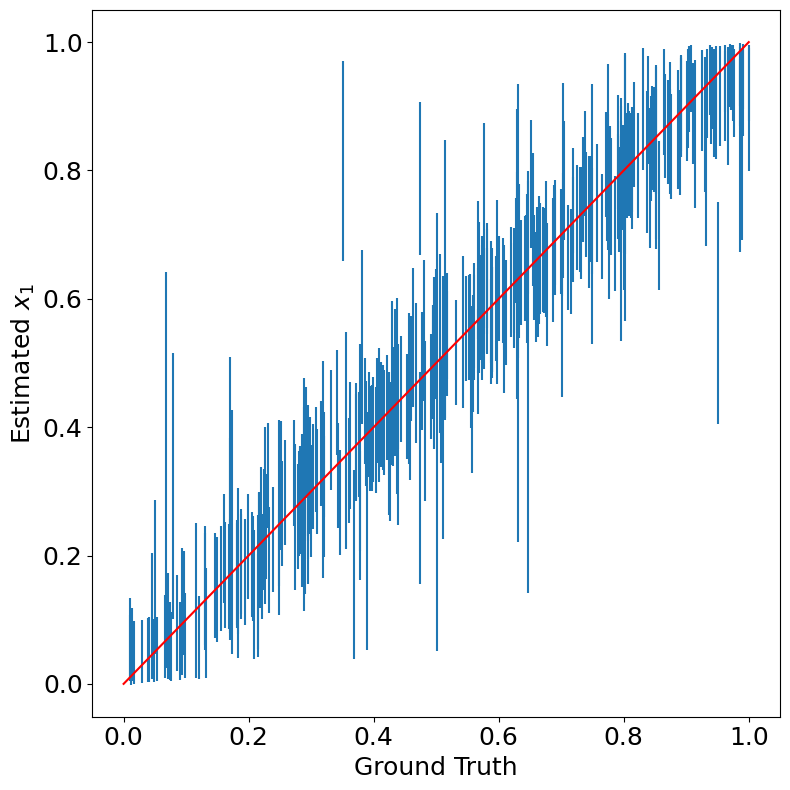

In [43]:
fig, ax = plt.subplots(1, 1, figsize=NoteBookVariables.figsize)

locs1_err = (torch.stack((bliss_locs1_ci_lower, bliss_locs1_ci_upper), dim=0) - bliss_locs1.unsqueeze(0)).abs()
ax.errorbar(x=target_locs1, y=bliss_locs1, yerr=locs1_err, fmt="none")
x = [0, 1]
y = [0, 1]
ax.plot(x, y, color="red")
ax.set_ylabel("Estimated $x_1$", fontsize=NoteBookVariables.font_size)
ax.set_xlabel("Ground Truth", fontsize=NoteBookVariables.font_size)
ax.tick_params(labelsize=NoteBookVariables.font_size)

fig.tight_layout()
fig.savefig(output_dir / "locs1_ci.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()

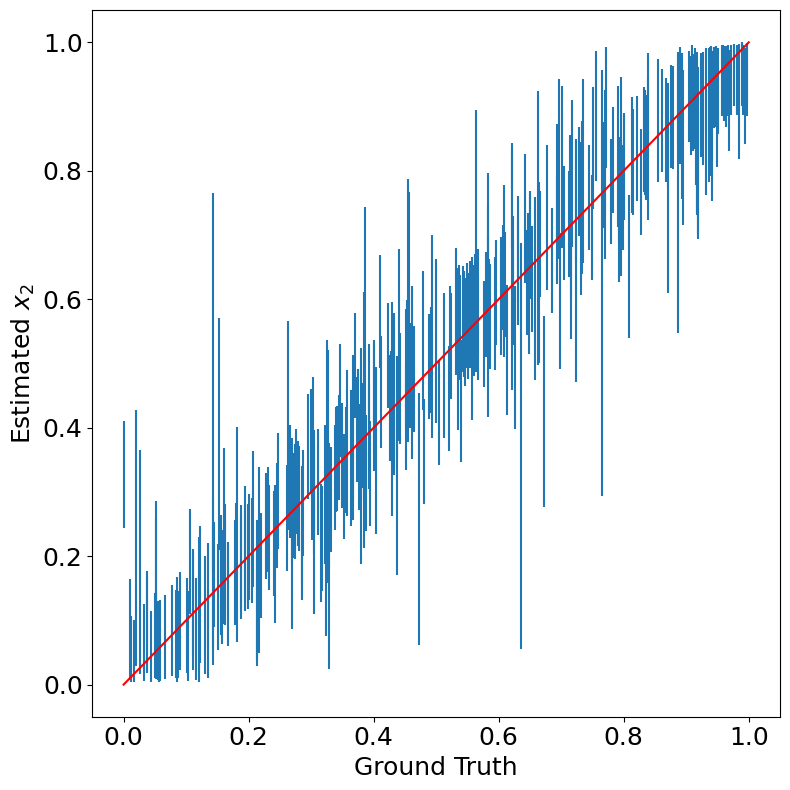

In [42]:
fig, ax = plt.subplots(1, 1, figsize=NoteBookVariables.figsize)

locs2_err = (torch.stack((bliss_locs2_ci_lower, bliss_locs2_ci_upper), dim=0) - bliss_locs2.unsqueeze(0)).abs()
ax.errorbar(x=target_locs2, y=bliss_locs2, yerr=locs2_err, fmt="none")
x = [0, 1]
y = [0, 1]
ax.plot(x, y, color="red")
ax.set_ylabel("Estimated $x_2$", fontsize=NoteBookVariables.font_size)
ax.set_xlabel("Ground Truth", fontsize=NoteBookVariables.font_size)
ax.tick_params(labelsize=NoteBookVariables.font_size)

fig.tight_layout()
fig.savefig(output_dir / "locs2_ci.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()